In [1]:
"""
의료영상 데이터셋 구축 튜토리얼 - TorchIO를 이용한 CT/CBCT 2D 슬라이스 데이터로더

이 노트북에서는 3D 의료영상(CT/CBCT)에서 2D 슬라이스를 추출하여 
딥러닝 모델 학습에 사용할 수 있는 데이터로더를 만드는 방법을 배웁니다.

주요 학습 내용:
1. TorchIO를 사용한 3D 의료영상 로딩
2. 데이터 전처리 및 증강 (Data Augmentation)
3. 2D 슬라이스 패치 샘플링
4. PyTorch DataLoader와 연동
5. 슬라이딩 윈도우 추론 (Sliding Window Inference)
"""

# 필요한 라이브러리들 import
import autorootcwd  # 프로젝트 루트 디렉토리 자동 설정
import torch        # PyTorch 딥러닝 프레임워크
import torch.nn as nn
import torchio as tio  # 의료영상 처리 전용 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# PyTorch CUDA 관련 경고 메시지 숨기기 (화면 정리용)
warnings.filterwarnings('ignore', message='.*pynvml.*')

/home/kanghyun/register-by-gen/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
"""
1단계: 의료영상 데이터셋 로딩 및 전처리 파이프라인 구축

이 섹션에서는:
- 여러 환자(Subject)의 CT/CBCT 영상 쌍을 로딩
- 의료영상 전용 전처리 기법들 적용
- 2D 슬라이스 패치 샘플링 설정
"""

import os
from torch.utils.data import DataLoader
import torch
import torchio as tio

# === 1) 데이터셋 로딩: 모든 환자의 CT/CBCT 영상 쌍 수집 ===
print("📁 데이터셋 로딩 중...")
data_dir = 'data/test_ct_cbct/AB_D'  # 데이터가 있는 디렉토리 경로

# 환자 폴더 목록 가져오기 (overviews 폴더는 제외)
subs = [d for d in os.listdir(data_dir) 
        if os.path.isdir(os.path.join(data_dir, d)) and d != 'overviews']

subjects = []  # TorchIO Subject 객체들을 담을 리스트

for sid in sorted(subs):  # 환자 ID 순으로 정렬하여 처리
    p = os.path.join(data_dir, sid)
    ct_path = os.path.join(p, 'ct.mha')      # CT 영상 파일 경로
    cbct_path = os.path.join(p, 'cbct.mha')  # CBCT 영상 파일 경로
    
    # 두 파일이 모두 존재하는지 확인
    if os.path.exists(ct_path) and os.path.exists(cbct_path):
        # TorchIO Subject 생성: 한 환자의 모든 영상을 묶는 컨테이너
        s = tio.Subject(
            ct=tio.Image(ct_path, type=tio.INTENSITY),      # CT 영상 (강도 이미지)
            cbct=tio.Image(cbct_path, type=tio.INTENSITY),  # CBCT 영상 (강도 이미지)
            subject_id=sid  # 환자 ID 저장
        )
        
        # TorchIO 내부 메타데이터 충돌 방지 (고급 사용자용)
        if 'type' in s and not isinstance(s['type'], tio.Image):
            s['modality_meta'] = s.pop('type')
        
        subjects.append(s)

print(f"✅ 총 {len(subjects)}명의 환자 데이터 로딩 완료")

# === 2) 데이터 전처리 파이프라인 구성 ===
print("🔧 전처리 파이프라인 설정 중...")

spatial = tio.Compose([
    # 강도 정규화: 이상값(outlier) 제거 후 정규화
    tio.RescaleIntensity(
        percentiles=(0.5, 99.5),  # 상하위 0.5% 값으로 클리핑
        include=["cbct", "ct"]     # CT와 CBCT 모두에 적용
    ),
    
    # Z-점수 정규화: 평균 0, 표준편차 1로 정규화
    tio.ZNormalization(include=["cbct", "ct"]),
    
    # 해부학적 표준 방향으로 정렬 (RAS+ 좌표계)
    tio.ToCanonical(include=["cbct", "ct"]),
    
    # === 데이터 증강 (Data Augmentation) ===
    # 좌우 반전 (50% 확률로 적용)
    tio.RandomFlip(axes=("LR",), include=["cbct", "ct"]),
    
    # 작은 회전 및 이동 변환 (의료영상에서는 보수적으로 적용)
    tio.RandomAffine(
        scales=(0.95, 1.05),      # 5% 범위 내 크기 변경
        degrees=(0, 0, 10),       # Z축 기준 ±10도 회전
        translation=(5, 5, 0),    # XY축 ±5픽셀 이동 (Z축은 고정)
        center='image',           # 이미지 중심 기준 변환
        include=["cbct", "ct"]
    ),
])

# TorchIO SubjectsDataset 생성: 여러 환자 데이터를 하나의 데이터셋으로 관리
dataset = tio.SubjectsDataset(subjects, transform=spatial)

print('=' * 50)

# === 3) 2D 슬라이스 패치 샘플링 설정 ===
print("🔪 2D 슬라이스 패치 샘플링 설정...")

# 패치 크기: 128x128 픽셀의 2D 슬라이스 (깊이=1)
patch_size = (128, 128, 1)

# 균등 샘플러: 3D 볼륨에서 랜덤하게 2D 슬라이스를 추출
sampler = tio.UniformSampler(patch_size)

# Queue: 효율적인 패치 생성 및 캐싱 시스템
queue = tio.Queue(
    dataset,                    # 사용할 데이터셋
    max_length=200,            # 메모리에 캐시할 최대 패치 수
    samples_per_volume=10,     # 각 3D 볼륨당 생성할 패치 수
    sampler=sampler,           # 패치 추출 방법
    num_workers=0,             # 멀티프로세싱 워커 수 (0=메인 프로세스만)
    shuffle_subjects=True,     # 환자 순서 섞기
    shuffle_patches=True       # 패치 순서 섞기
)

# PyTorch DataLoader: 배치 단위로 데이터 제공
loader = DataLoader(
    queue, 
    batch_size=8,          # 배치 크기: 한 번에 8개 슬라이스
    shuffle=False,         # Queue에서 이미 섞었으므로 False
    num_workers=0,         # 워커 수
    pin_memory=False       # GPU 메모리 고정 (메모리 부족시 False)
)
# 데이터로더에서 첫 번째 배치 가져오기
iter_loader = iter(loader)
batch = next(iter_loader)

# 배치 데이터 추출 및 차원 조정
x = batch['cbct'][tio.DATA].squeeze(-1)  # CBCT: (B, 1, H, W)
y = batch['ct'][tio.DATA].squeeze(-1)    # CT: (B, 1, H, W)

print(f"📊 배치 결과:")
print(f"   CBCT 형태: {x.shape}")
print(f"   CT 형태: {y.shape}")
print(f"   환자 ID들: {batch['subject_id']}")
print(f"   CBCT 값 범위: [{x.min():.3f}, {x.max():.3f}]")
print(f"   CT 값 범위: [{y.min():.3f}, {y.max():.3f}]")

📁 데이터셋 로딩 중...
✅ 총 2명의 환자 데이터 로딩 완료
🔧 전처리 파이프라인 설정 중...
🔪 2D 슬라이스 패치 샘플링 설정...
📊 배치 결과:
   CBCT 형태: torch.Size([8, 1, 128, 128])
   CT 형태: torch.Size([8, 1, 128, 128])
   환자 ID들: ['2ABD001', '2ABD001', '2ABD001', '2ABD001', '2ABD003', '2ABD003', '2ABD003', '2ABD003']
   CBCT 값 범위: [-0.772, 2.249]
   CT 값 범위: [-0.739, 2.442]


📊 두 번째 배치 정보:
   CBCT 형태: torch.Size([8, 1, 128, 128])
   CT 형태: torch.Size([8, 1, 128, 128])
   환자 ID들: ['2ABD003', '2ABD003', '2ABD001', '2ABD003', '2ABD001', '2ABD003', '2ABD001', '2ABD003']


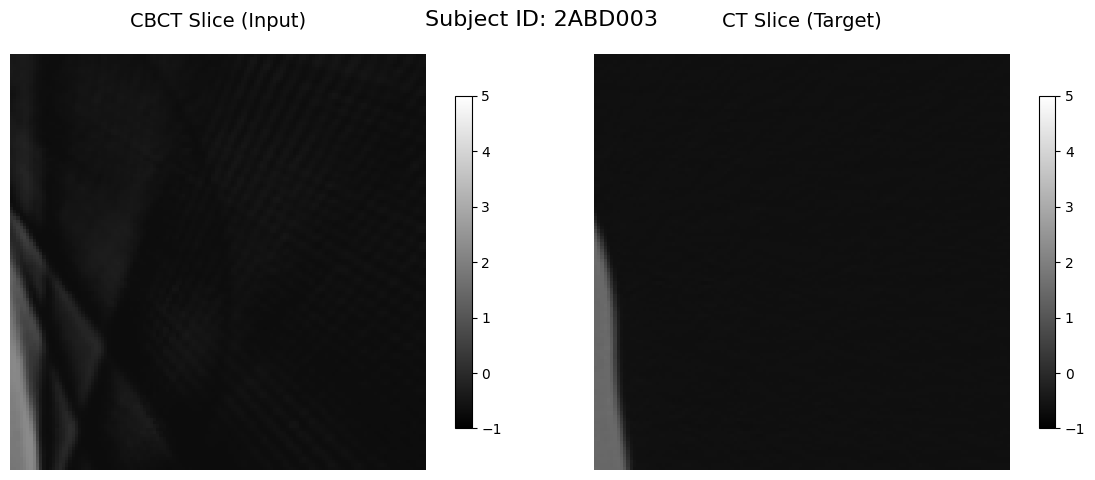


📈 배치 통계:
   CBCT - 평균: -0.103, 표준편차: 0.890
   CT   - 평균: -0.052, 표준편차: 0.949
   CBCT 값 범위: [-0.772, 2.249]
   CT 값 범위: [-0.741, 2.442]


In [3]:
"""
2단계: 샘플링된 2D 슬라이스 시각화

이 섹션에서는:
- 다음 배치 샘플링
- CBCT와 CT 슬라이스 쌍 시각화
- 데이터 품질 확인
"""

# 다음 배치 가져오기 (다른 환자들의 슬라이스)
batch = next(iter_loader)
x = batch['cbct'][tio.DATA].squeeze(-1)  # CBCT: (B, 1, H, W)
y = batch['ct'][tio.DATA].squeeze(-1)    # CT: (B, 1, H, W)

print(f"📊 두 번째 배치 정보:")
print(f"   CBCT 형태: {x.shape}")
print(f"   CT 형태: {y.shape}")
print(f"   환자 ID들: {batch['subject_id']}")

# === 시각화: 첫 번째 슬라이스 쌍 보기 ===
plt.figure(figsize=(12, 5))

# CBCT 슬라이스 표시
plt.subplot(1, 2, 1)
plt.imshow(x[0].numpy().squeeze(), cmap='gray', vmin=-1, vmax=5)
plt.axis('off')
plt.title('CBCT Slice (Input)', fontsize=14, pad=20)
plt.colorbar(shrink=0.8)

# CT 슬라이스 표시 (정답/타겟)
plt.subplot(1, 2, 2)
plt.imshow(y[0].numpy().squeeze(), cmap='gray', vmin=-1, vmax=5)
plt.axis('off')
plt.title('CT Slice (Target)', fontsize=14, pad=20)
plt.colorbar(shrink=0.8)

plt.suptitle(f'Subject ID: {batch["subject_id"][0]}', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# === 배치 전체의 통계 정보 ===
print(f"\n📈 배치 통계:")
print(f"   CBCT - 평균: {x.mean():.3f}, 표준편차: {x.std():.3f}")
print(f"   CT   - 평균: {y.mean():.3f}, 표준편차: {y.std():.3f}")
print(f"   CBCT 값 범위: [{x.min():.3f}, {x.max():.3f}]")
print(f"   CT 값 범위: [{y.min():.3f}, {y.max():.3f}]")

In [4]:
"""
3단계: 슬라이딩 윈도우 추론 (Sliding Window Inference) 구현

이 섹션에서는:
- 전체 3D 볼륨에 대한 추론 방법 구현
- 작은 CNN 모델 정의 (예시용)
- 슬라이딩 윈도우 기법으로 전체 볼륨 처리
- 추론 결과 저장
"""

import math, torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader

# 추론용 별도 데이터셋 생성 (처음 2명만 테스트)
test_dataset = tio.SubjectsDataset(subjects[:2], transform=spatial)

# === 추론 전용 전처리 파이프라인 ===
# 학습시와 달리 랜덤 변환은 제외하고 정규화만 적용
infer_tf = tio.Compose([
    tio.ToCanonical(include=['cbct','ct']),                    # 표준 방향 정렬
    tio.RescaleIntensity(percentiles=(0.5,99.5), include=['cbct','ct']),  # 강도 정규화
    tio.ZNormalization(include=['cbct','ct']),                 # Z-점수 정규화
])

# === 예시용 간단한 CNN 모델 정의 ===
class TinyConv2d(nn.Module):
    """
    초간단 2D CNN 모델 (데모용)
    실제로는 UNet, ResNet 등 더 복잡한 모델을 사용
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, 3, padding=1)   # 입력: 1채널 → 5채널
        self.conv2 = nn.Conv2d(5, 5, 3, padding=1)   # 5채널 → 5채널
        self.conv3 = nn.Conv2d(5, 1, 3, padding=1)   # 5채널 → 1채널 (출력)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)  # 마지막 레이어는 활성화 함수 없음
        return x

# 모델 초기화 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyConv2d().to(device).eval()  # 평가 모드로 설정
print(f"🔧 모델 로딩 완료 - 디바이스: {device}")

def floor_mul(n, k=16):
    """
    n을 k의 배수로 내림하는 함수
    CNN 모델에서 크기 호환성을 위해 사용 (보통 16 또는 32의 배수 필요)
    """
    if n >= k: 
        return (n // k) * k
    return n  # k보다 작으면 원본 유지

@torch.inference_mode()  # 그래디언트 계산 비활성화 (추론 속도 향상)
def sliding_window_infer_subject(subject: tio.Subject,
                                 batch_size=8, num_workers=0,
                                 overlap_xy=0):
    """
    슬라이딩 윈도우 기법으로 전체 3D 볼륨 추론
    
    Args:
        subject: 추론할 TorchIO Subject
        batch_size: 배치 크기
        num_workers: 워커 수  
        overlap_xy: XY 방향 겹침 픽셀 수 (품질 향상용)
    
    Returns:
        torch.Tensor: 추론된 3D 볼륨 (1, H, W, D)
    """
    print(f"🔮 추론 시작 - 환자: {subject.get('subject_id', 'Unknown')}")
    
    # 1) 추론 전용 전처리 적용 (랜덤 변환 없음)
    s = infer_tf(subject)
    
    # 2) 3D 볼륨 크기 정보 추출
    H = int(s['cbct'].shape[1])  # 높이
    W = int(s['cbct'].shape[2])  # 너비  
    D = int(s['cbct'].shape[3])  # 깊이 (슬라이스 수)
    
    print(f"   원본 크기: {H}×{W}×{D}")
    
    # 3) CNN 호환을 위해 크기를 16의 배수로 조정
    Ht = floor_mul(H, 16)
    Wt = floor_mul(W, 16)
    print(f"   조정 크기: {Ht}×{Wt}×{D}")
    
    # 4) 중앙 기준으로 크롭 (패딩은 하지 않음)
    s = tio.CropOrPad((Ht, Wt, D))(s)
    
    # 5) 슬라이딩 윈도우 설정
    patch_size = (Ht, Wt, 1)  # 전체 슬라이스를 한 번에 처리
    patch_overlap = (overlap_xy, overlap_xy, 0)  # 겹침 설정
    
    # 6) TorchIO GridSampler: 겹치는 패치들을 체계적으로 생성
    sampler = tio.inference.GridSampler(s, patch_size=patch_size, 
                                       patch_overlap=patch_overlap)
    
    # 7) GridAggregator: 겹치는 영역을 부드럽게 합치기
    aggregator = tio.inference.GridAggregator(sampler, overlap_mode='hann')
    
    # 8) 배치 단위로 추론 실행
    loader = DataLoader(sampler, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=False)
    
    patch_count = 0
    for patches in loader:
        # CBCT 데이터 추출 및 GPU로 이동
        x = patches['cbct'][tio.DATA].squeeze(-1).to(device)  # (B,1,Ht,Wt)
        
        # 모델 추론 실행
        y = model(x)  # (B,1,Ht,Wt) → (B,1,Ht,Wt)
        
        # 결과를 CPU로 이동하고 차원 복원
        y = y.unsqueeze(-1).cpu()  # (B,1,Ht,Wt,1)
        
        # 패치 위치 정보 가져오기
        locs = patches[tio.LOCATION]
        
        # Aggregator에 결과 추가 (겹치는 영역 자동 처리)
        aggregator.add_batch(y, locs)
        
        patch_count += x.shape[0]
        if patch_count % 50 == 0:
            print(f"   처리된 패치: {patch_count}")
    
    # 9) 최종 결과 생성 (겹친 영역들이 부드럽게 합쳐짐)
    out = aggregator.get_output_tensor()  # (1,Ht,Wt,D)
    print(f"   추론 완료! 출력 크기: {out.shape}")
    
    return out

🔧 모델 로딩 완료 - 디바이스: cuda


In [5]:
"""
4단계: 전체 볼륨 추론 실행 및 결과 저장

이 섹션에서는:
- 처음 2명의 환자에 대해 전체 볼륨 추론 실행
- 추론 결과를 의료영상 형식(.mha)으로 저장
- 원본 이미지의 공간 정보(affine) 보존
"""

# 추론 결과 저장할 디렉토리 생성
save_dir = 'pred_ct_vols'
os.makedirs(save_dir, exist_ok=True)
print(f"📁 저장 디렉토리: {save_dir}")

print("\n🚀 전체 볼륨 추론 시작...")

# 처음 2명의 환자에 대해 추론 실행
for idx, subj in enumerate(subjects[:2]):
    print(f"\n{'='*60}")
    print(f"환자 {idx+1}/2 처리 중...")
    
    # 슬라이딩 윈도우 추론 실행
    pred_ct = sliding_window_infer_subject(
        subj, 
        batch_size=16,    # 배치 크기 증가로 속도 향상
        num_workers=0,    # 멀티프로세싱 (메모리 부족시 0으로 설정)
        overlap_xy=30     # 30픽셀 겹침으로 경계 부드럽게 처리
    )
    
    # 환자 ID 가져오기
    sid = subj.get('subject_id', f'subj_{idx}')
    
    # 추론 결과를 TorchIO 이미지 객체로 변환
    # 원본 CBCT의 공간 정보(affine matrix)를 그대로 사용하여
    # 의료영상 좌표계 정보를 보존
    out_img = tio.ScalarImage(
        tensor=pred_ct,              # 추론 결과 텐서
        affine=subj['cbct'].affine   # 원본 공간 정보 보존
    )
    
    # .mha 형식으로 저장 (의료영상 표준 형식)
    output_path = os.path.join(save_dir, f'{sid}_predct_floor16.mha')
    out_img.save(output_path)
    
    print(f'✅ 저장 완료: {sid} → 크기: {pred_ct.shape}')
    print(f'   파일: {output_path}')

print(f"\n🎉 모든 추론 완료! 결과는 '{save_dir}' 폴더에 저장됨")
print(f"💡 저장된 파일들:")
for file in os.listdir(save_dir):
    if file.endswith('.mha'):
        print(f"   - {file}")

print(f"\n📋 요약:")
print(f"   - 처리된 환자 수: 2명")
print(f"   - 모델: TinyConv2d (예시용)")
print(f"   - 추론 방식: 슬라이딩 윈도우 (겹침 30픽셀)")
print(f"   - 출력 형식: .mha (의료영상 표준)")
print(f"   - 공간 정보: 원본 CBCT affine 보존")

📁 저장 디렉토리: pred_ct_vols

🚀 전체 볼륨 추론 시작...

환자 1/2 처리 중...
🔮 추론 시작 - 환자: 2ABD001
   원본 크기: 435×452×99
   조정 크기: 432×448×99
   추론 완료! 출력 크기: torch.Size([1, 432, 448, 99])
✅ 저장 완료: 2ABD001 → 크기: torch.Size([1, 432, 448, 99])
   파일: pred_ct_vols/2ABD001_predct_floor16.mha

환자 2/2 처리 중...
🔮 추론 시작 - 환자: 2ABD003
   원본 크기: 430×450×68
   조정 크기: 416×448×68
   추론 완료! 출력 크기: torch.Size([1, 416, 448, 68])
✅ 저장 완료: 2ABD003 → 크기: torch.Size([1, 416, 448, 68])
   파일: pred_ct_vols/2ABD003_predct_floor16.mha

🎉 모든 추론 완료! 결과는 'pred_ct_vols' 폴더에 저장됨
💡 저장된 파일들:
   - 2ABD001_predct_floor16.mha
   - 2ABD003_predct_floor16.mha

📋 요약:
   - 처리된 환자 수: 2명
   - 모델: TinyConv2d (예시용)
   - 추론 방식: 슬라이딩 윈도우 (겹침 30픽셀)
   - 출력 형식: .mha (의료영상 표준)
   - 공간 정보: 원본 CBCT affine 보존


In [6]:
"""
🎓 튜토리얼 완료 및 핵심 요약

축하합니다! TorchIO를 이용한 의료영상 데이터셋 구축을 성공적으로 완료했습니다.

=== 🔑 핵심 개념 요약 ===

1️⃣ TorchIO Subject: 한 환자의 모든 영상(CT, CBCT 등)을 묶는 컨테이너
2️⃣ 전처리 파이프라인: 의료영상 특화 정규화 및 데이터 증강 기법들
3️⃣ UniformSampler: 3D 볼륨에서 2D 슬라이스 패치를 랜덤 샘플링
4️⃣ Queue 시스템: 효율적인 패치 생성과 메모리 관리
5️⃣ Sliding Window Inference: 전체 볼륨 추론을 위한 표준 기법

=== 🚀 다음 단계 가이드 ===

✅ 학습 루프 구현:
   - 이 데이터로더를 이용해 실제 딥러닝 모델 학습
   - Loss 함수: MSE, L1, SSIM 등 선택
   - Optimizer: Adam, AdamW 등 사용

✅ 모델 개선:
   - TinyConv2d → UNet, ResNet, Transformer 등으로 교체
   - 더 복잡한 아키텍처로 성능 향상

✅ 평가 메트릭:
   - PSNR, SSIM, LPIPS 등 의료영상 품질 평가 지표
   - 임상 전문가 평가 고려

✅ 실제 배포:
   - 모델 최적화 (TensorRT, ONNX)
   - 의료기기 규제 준수 (FDA, CE 등)

=== 💡 추가 학습 리소스 ===

📚 TorchIO 공식 문서: https://torchio.readthedocs.io/
📚 의료영상 딥러닝: MONAI 라이브러리 활용
📚 PyTorch 공식 튜토리얼: https://pytorch.org/tutorials/

🎯 이제 여러분만의 의료영상 AI 모델을 만들어보세요!
"""

print("🎉 튜토리얼 완성! 수고하셨습니다! 🎉")
print("💪 이제 진짜 모델 학습을 시작할 차례입니다!")

🎉 튜토리얼 완성! 수고하셨습니다! 🎉
💪 이제 진짜 모델 학습을 시작할 차례입니다!
